# Temporal Shift Detection in ICU Patient Data


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

sns.set(style="whitegrid")
%matplotlib inline


In [13]:
import numpy as np
np.__version__
np.sin(np.array([0, 1]))


array([0.        , 0.84147098])

# Load Patient Data with Timestamps




In [23]:
# Load patient data with timestamps and discharge outcome
df_pat = pd.read_csv(
    "eicu-collaborative-research-database-2.0/patient.csv.gz",
    compression="gzip",
    usecols=["patientunitstayid", "hospitalid", "unittype", "unitadmittime24", "unitdischargestatus"]
)

# Clean + define time bucket + mortality
df_pat["unitadmittime24"] = pd.to_datetime(df_pat["unitadmittime24"], errors="coerce")
df_pat["mortality"] = df_pat["unitdischargestatus"].str.lower().eq("expired").astype(int)
median_time = df_pat["unitadmittime24"].median()
df_pat["time_bucket"] = np.where(df_pat["unitadmittime24"] < median_time, "early", "late")
print("Split cutoff:", median_time)


# Inspect output
df_pat.info()
df_pat.head()

/var/folders/5y/v983zg9s5mj989l04vv_c3lc0000gn/T/ipykernel_30260/196680420.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pat["unitadmittime24"] = pd.to_datetime(df_pat["unitadmittime24"], errors="coerce")


Split cutoff: 2025-06-27 14:09:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200859 entries, 0 to 200858
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   patientunitstayid    200859 non-null  int64         
 1   hospitalid           200859 non-null  int64         
 2   unittype             200859 non-null  object        
 3   unitadmittime24      200859 non-null  datetime64[ns]
 4   unitdischargestatus  200825 non-null  object        
 5   mortality            200859 non-null  int64         
 6   time_bucket          200859 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 10.7+ MB


,patientunitstayid,hospitalid,unittype,unitadmittime24,unitdischargestatus,mortality,time_bucket
0,141168,59,Med-Surg ICU,2025-06-27 15:54:00,Expired,1,late
1,141178,60,Med-Surg ICU,2025-06-27 09:10:00,Alive,0,early
2,141179,60,Med-Surg ICU,2025-06-27 09:18:00,Alive,0,early
3,141194,73,CTICU,2025-06-27 07:18:00,Alive,0,early
4,141196,67,Med-Surg ICU,2025-06-27 22:00:00,Alive,0,late


In [24]:
# Load diagnosis data
df_diag = pd.read_csv("eicu-collaborative-research-database-2.0/diagnosis.csv.gz", compression="gzip")

# Merge time + mortality
df = df_diag.merge(df_pat[["patientunitstayid", "time_bucket", "mortality"]], on="patientunitstayid", how="left")
df = df.dropna(subset=["time_bucket", "diagnosispriority"])

# Encode diagnosispriority
df["diagnosispriority_encoded"] = pd.factorize(df["diagnosispriority"])[0]

# Inspect merged dataset
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710672 entries, 0 to 2710671
Data columns (total 10 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   diagnosisid                int64 
 1   patientunitstayid          int64 
 2   activeupondischarge        bool  
 3   diagnosisoffset            int64 
 4   diagnosisstring            object
 5   icd9code                   object
 6   diagnosispriority          object
 7   time_bucket                object
 8   mortality                  int64 
 9   diagnosispriority_encoded  int64 
dtypes: bool(1), int64(5), object(4)
memory usage: 188.7+ MB


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority,time_bucket,mortality,diagnosispriority_encoded
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other,late,1,0
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other,late,1,0
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other,late,1,0
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other,late,1,0
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other,late,1,0


# Define Temporal Cohorts




In [25]:
# Encode diagnosispriority to numeric
# df["diagnosispriority_encoded"] = pd.factorize(df["diagnosispriority"])[0]
# feature = "diagnosispriority_encoded"

# Visualize Feature Distribution Over Time



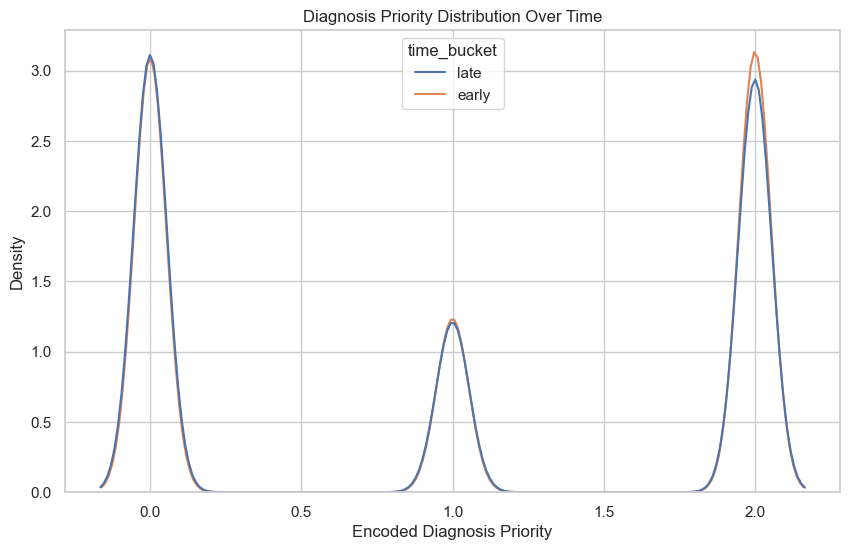

In [26]:
# Plot KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="diagnosispriority_encoded", hue="time_bucket", common_norm=False)
plt.title("Diagnosis Priority Distribution Over Time")
plt.xlabel("Encoded Diagnosis Priority")
plt.ylabel("Density")
plt.show()

# Statistical Test for Temporal Drift



In [27]:
# KS test
group1 = df[df["time_bucket"] == "early"]["diagnosispriority_encoded"].dropna()
group2 = df[df["time_bucket"] == "late"]["diagnosispriority_encoded"].dropna()
ks_stat, p_val = ks_2samp(group1, group2)
print(f"KS Statistic = {ks_stat:.4f}, P-value = {p_val:.4e}")


KS Statistic = 0.0158, P-value = 1.5382e-147


# Save Temporal Cohort Splits



In [28]:
early_df = df[df["time_bucket"] == "early"]
late_df = df[df["time_bucket"] == "late"]

Path("cohorts").mkdir(exist_ok=True)
early_df.to_csv("cohorts/train_temporal.csv", index=False)
late_df.to_csv("cohorts/test_temporal.csv", index=False)


In [29]:
#making sample size 
# Load saved temporal splits
df_train = pd.read_csv("cohorts/train_temporal.csv")
df_test = pd.read_csv("cohorts/test_temporal.csv")

print("Train cohort size:", len(df_train))
print("Test cohort size:", len(df_test))

# Sample if possible, else use full sets
if len(df_train) >= 500 and len(df_test) >= 500:
    sample_df_train = df_train.sample(n=500, random_state=42)
    sample_df_test = df_test.sample(n=500, random_state=42)
else:
    print("⚠️ Not enough data to sample 500. Using full cohorts.")
    sample_df_train = df_train.copy()
    sample_df_test = df_test.copy()

# Save sample
sample_df_train.to_csv("cohorts/train_temporal_sample.csv", index=False)
sample_df_test.to_csv("cohorts/test_temporal_sample.csv", index=False)


Train cohort size: 1449650
Test cohort size: 1261022


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Ensure there’s enough data to train
if len(sample_df_train) > 0 and len(sample_df_test) > 0:
    X_train = sample_df_train[["diagnosispriority_encoded"]]
    y_train = sample_df_train["mortality"]
    X_test = sample_df_test[["diagnosispriority_encoded"]]
    y_test = sample_df_test["mortality"]

    if len(X_train["diagnosispriority_encoded"].unique()) > 1 and y_train.nunique() > 1:
        model = LogisticRegression().fit(X_train, y_train)
        preds = model.predict_proba(X_test)[:, 1]
        auroc = roc_auc_score(y_test, preds)
        print(f"Test AUROC (early→late): {auroc:.4f}")
    else:
        print("Not enough variation in training data to train a model.")
else:
    print("Empty training or test data — check your cohort creation earlier in the notebook.")


Test AUROC (early→late): 0.4873


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train = sample_df_train[["diagnosispriority_encoded"]]
y_train = sample_df_train["mortality"]
X_test = sample_df_test[["diagnosispriority_encoded"]]
y_test = sample_df_test["mortality"]

model = LogisticRegression().fit(X_train, y_train)
auroc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"Test AUROC (early→late): {auroc:.4f}")


Test AUROC (early→late): 0.4873


# Summary

This notebook successfully:
- Identified a temporal feature (`hospitaladmitoffset`)
- Defined early vs. late admission cohorts
- Quantified distribution shift in clinical features
- Saved shifted datasets for modeling

These steps support later experiments in:
- Evaluating baseline model robustness over time
- Testing In-Context Learning (ICL) strategies for temporal generalization
